# Ejemplo de simulación

En este notebook se va a explicar como definir los componentes necesarios para realizar una simulación en el dispositivo `braket_ahs`. Además, se muestran los resultados que devuelve este, diferentes maneras de mostrar gráficamente los resultados y se describen las métricas que se han utilizado en el proyecto. La organización del notebook es el siguiente:
* Definir el grafo

* Definir los _drivings_

* Ejecutar la simulación

* Optimización de _drivings_

* Definición de _Hardness Parameter_ (HP)

In [6]:
import networkx as nx
from networkx.classes.graph import Graph

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.ahs.driving_field import DrivingField
from braket.ahs.local_detuning import LocalDetuning
from braket.timings.time_series import TimeSeries
from braket.devices import LocalSimulator

from src.ahs_utils import show_register, show_drive_and_local_detuning_v2, show_final_avg_density
from src.drivings_aitor import Drivings2
from src.aitor_utils import C_from_gr, Gurobi_solver, Gurobi_to_gr

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

import time as tm
import itertools

from scipy import optimize

# Definir el grafo

En este caso, a modo de ejemplo, vamos a utilziar un grafo de 3x3 sin eleminar ningún nodo y solo vamos a conectar los primeros vecinos.

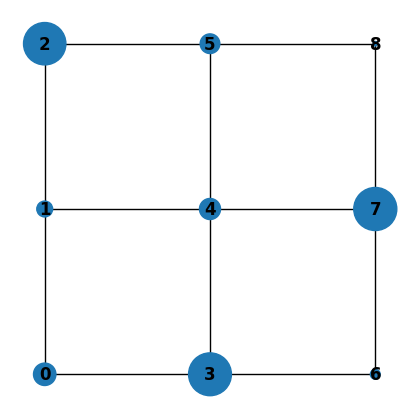

In [7]:
# Características del grafo
n = 3         # tamaño de la cuadrícula (3x3)
scale = 5e-6   # distancia entre átomos vecinos

# Crear el grafo vacío
G = nx.Graph()

# Añadir nodos
for i in range(n**2):
    G.add_node(i)

# Posiciones escaladas de los nodos
pos = {0: (0,0), 1: (0,1*scale), 2: (0,2*scale),
       3: (1*scale,0), 4: (1*scale,1*scale), 5: (1*scale,2*scale),
       6: (2*scale,0), 7: (2*scale,1*scale), 8: (2*scale,2*scale)}
# Guardar las posiciones en los nodos
for node, position in pos.items():
    G.nodes[node]['pos'] = position

# Añadir aristas
for i in range(n**2):
    for j in range(i+1,n**2):
        distancia = np.linalg.norm(np.array(pos[i])-np.array(pos[j]))
        if distancia <= scale:
            G.add_edge(i,j)

# Peso de cada nodo
weights = [0.26, 0.13, 0.93, 0.95, 0.23, 0.20, 0.05, 0.96, 0.01] 
# Guardar los pesos en los nodos
for node in G.nodes():
    G.nodes[node]['weight'] = weights[node]

# Dibujar grafo
plt.figure(figsize=(4,4))
nx.draw(G, pos, with_labels=True, node_size=[v*1000 for v in weights], font_weight='bold')
plt.axis('equal')
plt.show()



En este grafo el tamaño de los nodos indica el peso asociado (nodos más grandes indican pesos mayores). Para este grafo, vemos que si quisieramos resolver el MIS (donde se busca encontrar el subconjunto independendiente con mayor número de nodos), la solución sería el subconjunto de nodos $S=(0,2,4,6,8)$. Sin embargo, el MWIS busca encontrar el subconjunto independiente que maximice la suma de los pesos de los nodos que lo componen. Los pesos de los nodos son $$W=[0.26, 0.13, 0.93, 0.95, 0.23, 0.20, 0.05, 0.96, 0.01]\,.$$ Fácilmente vemos que la solución al MWIS es $S=(2,3,7)$, con un peso de $2.84$, mientras que la suma de los pesos de la solución del MIS es de $1.48$.

# Definir los _drivings_

Los drivings se pueden definir de multiples maneras. En nuestro caso, para hacerlo llamamos a la función Drivings2 definida en el `aitor_utils.py`. Esta genera los drivings en base a la parametrización explicada en capítulo 4 de la memoria. 

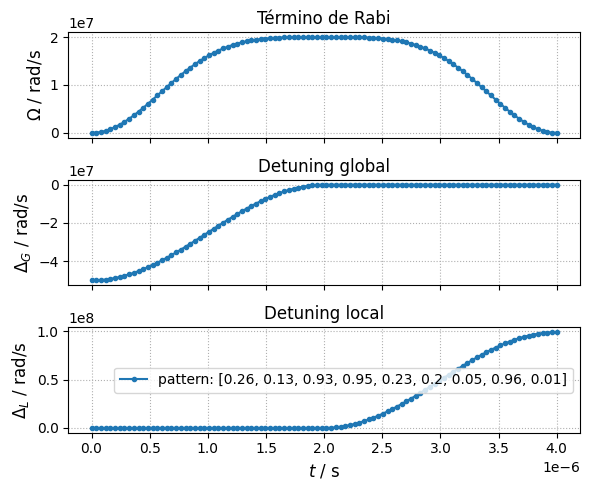

In [8]:
# Parámetros del Hamiltoniano
time_max = 4 # microsegundos
Omega_max = 20 *1e6 # RAD/s
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7 #RAD/S
Delta_0 = (1/2, 1/4, 1/2, 3/4)


# Calulamos los drivings
drive, local_detuning_drive, delta_local_array, time = Drivings2(time_max, Omega_max, Delta_max, Delta_local_max, weights, Delta_0)
# Mostramos los drivings
show_drive_and_local_detuning_v2(drive , local_detuning_drive)


# Ejecutar la simulación

In [9]:
# Defino la disposición de los átomos (objeto AtomArrangement) a partir de las posiciones de los nodos del grafo
atoms = AtomArrangement()
for i in range(n**2):
    atoms.add(pos[i])

# Defino el hamiltoniano
program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive,
                                        register=atoms)
# Defino el dispositivo
device = LocalSimulator("braket_ahs")

# Defino los parámetros de la simulación
shots = 1000
steps = 30
blockade_radius = scale*1.1

# Ejecuto la simulación
results = device.run(program, shots=shots, steps=steps, blockade_radius=blockade_radius).result()

# Obtengo un diccionario con los bitstrings y sus respectivas frecuencias
counters = results.get_counts()
gr_list = list(counters.keys())
Counts = list(counters.values())

A la función `run()` se le pasan los siguientes argumentos:

- **`program`**: Especifica la tarea a ejecutar, en este caso, la evolución del Hamiltoniano definida previamente.

- **`shots`**: Número de veces que se repite la simulación. A mayor número de *shots*, más tiempo de ejecución se requiere, pero se obtienen resultados más robustos estadísticamente.

- **`steps`**: Número de pasos intermedios en la evolución temporal. Si los *drivings* varían bruscamente, se recomienda aumentar este valor para una integración más precisa.

- **`blockade_radius`**: Define la distancia mínima permitida entre dos átomos excitados. Este parámetro se utiliza para aplicar la condición de bloqueo de Rydberg de forma anticipada, descartando configuraciones inválidas antes de realizar la simulación. Esto reduce significativamente el tiempo de cálculo en instancias de mayor tamaño.


En cada *shot* se mide el resultado y se guarda en una cadena que llamamos *bitstring*. El *bitstring* está formado por '0' y '1' (o 'r' y 'g'), e indica el estado medido de cada átomo. En este caso, como tenemos 9 nodos, el *bitstring* tiene una longitud de 9 caracteres. Mediante el método `get_counts()` podemos ver la frecuencia experimental de cada *bitstring*.


In [10]:
# Calculamos la energía de cada bitstring obtenido en la simulacion
counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
counters = counters.sort_values(by='Counts', ascending=False)
counters.head()


,bitstring,Counts
17,ggrrgggrg,266
27,rgrggggrg,174
10,ggrggggrg,170
15,ggrrggggg,147
16,ggrrggggr,52


De estos resultados, podemos realizar una variedad de estudios.

#### Observar las soluciones más probables.

Conjunto independiente de 1-ésima salida más probable


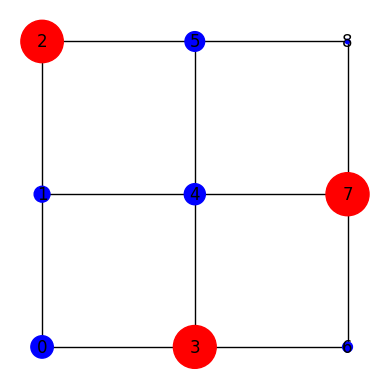

Conjunto independiente de 2-ésima salida más probable


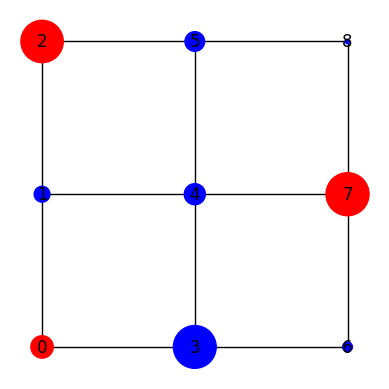

Conjunto independiente de 3-ésima salida más probable


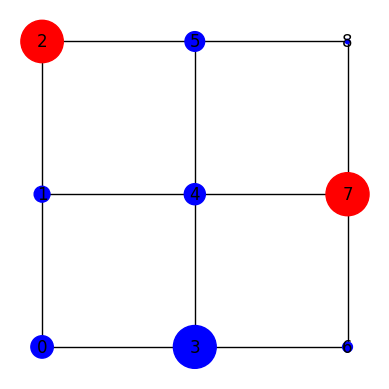

In [11]:
from collections import Counter

states = ['e', 'r', 'g']
state_labels = []
for shot in results.measurements:
    pre = shot.pre_sequence
    post = shot.post_sequence
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

# Número de grafos que queremos que muestre
num_graphs = 3
most_frequent_regs = occurence_count.most_common(num_graphs)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    vert_colors = ['red' if (most_frequent_regs[ii][0][i] == 'r') else 'blue' for i in range(len(most_frequent_regs[ii][0]))]
    print(f'Conjunto independiente de {ii+1}-ésima salida más probable')
    nx.draw(G, pos = {ii: (ii//n,ii%n) for ii in G.nodes()},
            ax=ax, with_labels=True, node_color=vert_colors, node_size=[v*1000 for v in weights])
    plt.show()

En estas figuras, se han coloreado de rojo (azul) los cúbits que se han medido en el estado 1 (0). Vemos que el resultado más probable coincide con la solución. Además, los siguientes resultados más probables contienen al menos dos de los nodos de la solución, por lo que tampoco se alejan mucho. Asimismo, al introducir el parámetro `rydberg_blockade` nos aseguramos de que ninguno de ellos viola la condicón de subconjunto independiente.

#### Observar la densidad de Rydberg promedio
La densidad de Rydberg promedio indica a la probabilidad frecuentista de que un nodo se haya medido en el estado de Rydberg. Así, lo ideal sería que los átomos que formen parte de la solución tengan una densidad de 1 y los demás átomos 0.

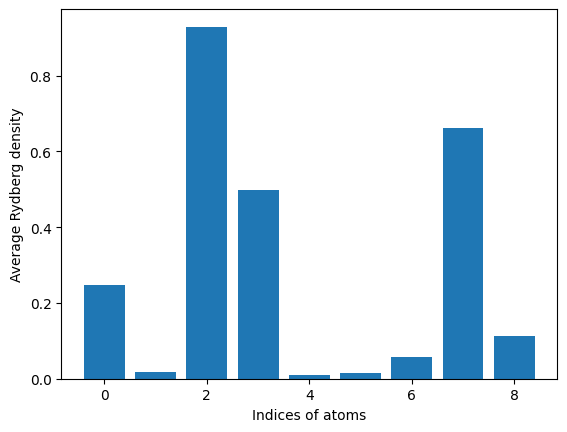

In [12]:
show_final_avg_density(results)

En esta figura se muestra la densidad promedio de Rydberg para cada átomo, es decir, la probabilidad media de que cada uno aparezca en el estado de Rydberg. Como se puede observar, los resultados no se ajustan completamente al caso ideal. No obstante, los átomos con mayor probabilidad de encontrarse en el estado de Rydberg coinciden con aquellos que forman parte de la solución óptima.


#### Evaluar los resultsados en la función de coste del MWIS
Por otro lado, podemos evaluar cada _bitstring_ en nuestra función de coste y evaluar "cómo de buenos" son estos resultados. Para ello vamos a introducir dos métricas muy utilizadas en este campo:
* **_Approximation Ratio_ (AR)**: <mark>Acabar esto</mark>
* **_Success Probability_ (SP)**: El SP es la probabilidad frecuentista de obtener la solución correcta.

In [13]:
# Evaluamos la función de coste en cada bitstring
counters['e_H'] = [C_from_gr(gr, weights, G.edges()) for gr in counters['bitstring']]

# Obtenemos la solución correcta mediante el algoritmo de Gurobi
optimal_value, opt_solutions = Gurobi_solver(G)
gur_solution = Gurobi_to_gr(opt_solutions, len(G.nodes()))

# Calculamos el SP
if gur_solution in list(counters['bitstring']):
    succ = float(list(counters[counters['bitstring'] == gur_solution]['Counts'])[0] / shots)
else:
    succ = 0

# Calculamos el AR
ar = float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value)
print(f'SP: {succ}, AR: {ar}')

Restricted license - for non-production use only - expires 2025-11-24


SP: 0.266, AR: 0.7214859154929578


De una manera más visual, podemos representar un histograma de las energías para comparar con la solución correcta.

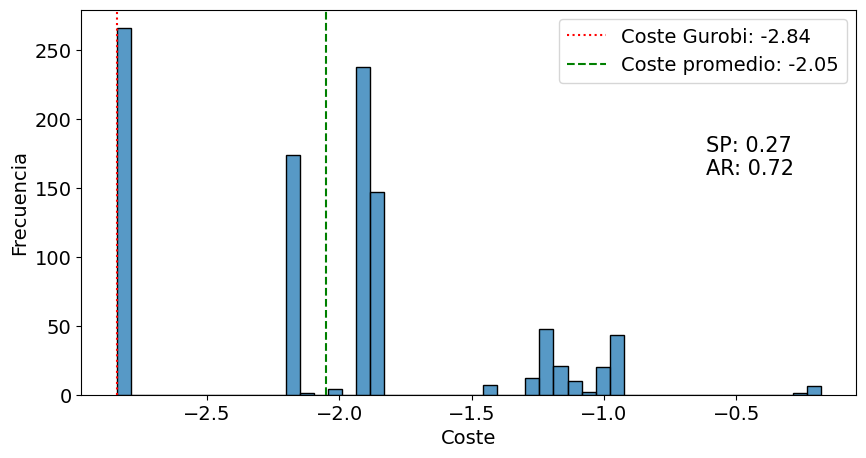

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(data=counters, x='e_H', weights='Counts', bins=50)
plt.xlabel('Coste', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Línea vertical en el valor óptimo
plt.axvline(optimal_value, color='red', linestyle='dotted', label=f"Coste Gurobi: {round(optimal_value, 2)}")

# Línea vertical en la energía promedio
plt.axvline(sum(counters['e_H'] * counters['Counts']) / shots, color='green', linestyle='--', label=f"Coste promedio: {round(sum(counters['e_H'] * counters['Counts']) / shots, 2)}")

# Añadimos texto con SP y AR
plt.text(0.75, 0.55, f'SP: {round(succ, 2)}\nAR: {round(ar, 2)}', fontsize=15, transform=plt.gcf().transFigure)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.show()


En el caso ideal, la línea vertical verde se superpondría con la roja, de manera que la energía promedio obtenida coincidiría exactamente con la energía de la solución. Sin embargo, esto no siempre ocurre de forma automática, ya que el resultado final depende en gran medida de los *drivings* que utilicemos para definir la evolución del sistema. Por esta razón, podemos plantear un proceso de optimización sobre los *drivings* con el objetivo de acercar la distribución de energía al estado óptimo y maximizar la probabilidad de éxito.


# Optimización de _drivings_


En este caso, vamos a realizar una optimización de _drivings_ mediante el método de COBYLA maximizando el AR.

Defino una función de coste, donde para una disposición de atomos, unos pesos y los drivings, me devuelve los resultados de la simulación y la energía media.

In [15]:
def loss(atoms: AtomArrangement, graph: Graph, pattern: list, Delta_local_0: list, show_drive=False):
    Delta_0 = (1/2, 1/4, Delta_local_0[0], Delta_local_0[1])

    # Defino los drivings
    drive, local_detuning_drive, delta_local_array, time = Drivings2(time_max, Omega_max, Delta_max, Delta_local_max, 
                                                                     pattern, Delta_0)

    # Defino el hamiltoniano
    program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive,
                                          register=atoms)
    device = LocalSimulator("braket_ahs")

    # Ejecuto la simulación
    results = device.run(program, shots=shots, steps=steps, blockade_radius=blockade_radius).result()
    
    # Obtengo un diccionario con los bitstrings y sus respectivas frecuencias
    counters = results.get_counts() #{'gggggggrg': 1, 'ggggrgggg': 3...}
    gr_list = list(counters.keys())
    Counts = list(counters.values())

    # Calculo la energía de cada estado
    Cost_f = [C_from_gr(gr, nx.get_node_attributes(G, 'weight') , graph.edges()) for gr in gr_list]

    # Calculo una media de las energías
    Mean_E = sum(Cost_f[i] * Counts[i] for i in range(len(Cost_f))) / sum(Counts)

    if show_drive:
        show_drive_and_local_detuning_v2(drive , local_detuning_drive)
    
    # Minimizar la energía media equivale a maximizar el AR
    return Mean_E, results, delta_local_array


A modo de juguete, vamos a optimizar únicamente los parámetros del _detuning_ local partiendo de los _drivings_ que hemos definido al inicio del notebook.

Energía media inicial: -1.7432600000000003
Drivings finales:


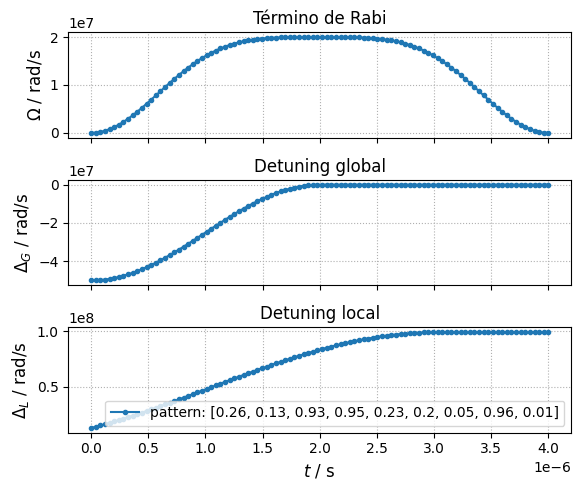

Optimization terminated successfully.
Energía media final: -2.6429699999999996
Parámetros finales: [0.9961754  0.26145753]
Tiempo de ejecución: 11.1978 s


In [16]:
# Punto inicial: mismos drivings que antes
Delta_local_0 = (1/4, 3/4) # Mismos drivings que antes
initial_Mean_E, initial_registers, initial_Deltas = loss(atoms, G, weights, Delta_local_0, show_drive=False)
print(f"Energía media inicial: {initial_Mean_E}")
from scipy.optimize import Bounds
# Busco los parámetros óptimos
print('Drivings finales:')
start = tm.time()
np.random.seed(92) 
optresult = optimize.minimize(lambda x: loss(atoms, G, weights, x)[0],
                              Delta_local_0, method='COBYLA', options={'maxiter': 200, 'tol': 1e-5}, bounds=Bounds(0, 1, True))
stop = tm.time()

# Guardo el registro óptimo
final_Mean_E, final_registers, final_Deltas = loss(atoms, G, weights, optresult.x, show_drive=True)
print(optresult.message)
print(f"Energía media final: {final_Mean_E}")
print(f"Parámetros finales: {optresult.x}")
print(f"Tiempo de ejecución: {round(stop-start, 4)} s")

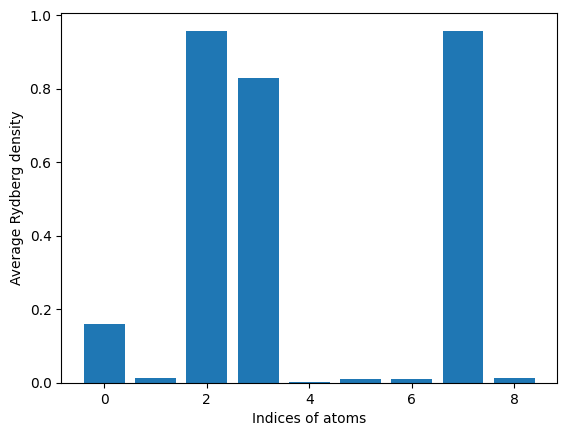

In [17]:
show_final_avg_density(final_registers)

Mediante esta simple optimización, vemos que los resultados han mejorado de manera considerable. La gráfica de la densidad de Rydberg promedia se acerca más al caso ideal, y parece que ahora el sistema se decanta más por los átomos que forman parte de la solución.

SP: 0.789, AR: 0.9306232394366196


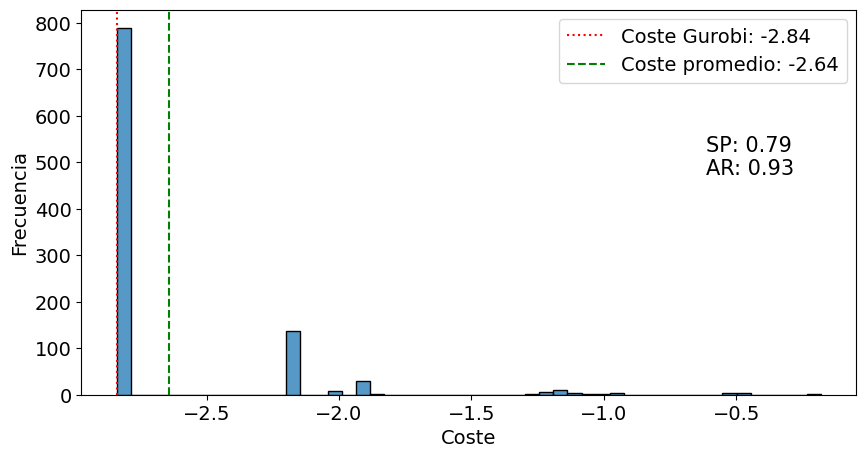

In [18]:
counters = final_registers.get_counts()
gr_list = list(counters.keys())
Counts = list(counters.values())
# Calculamos la energía de cada bitstring obtenido en la simulacion
counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
counters = counters.sort_values(by='Counts', ascending=False)

# Evaluamos la función objetivo en cada bitstring
counters['e_H'] = [C_from_gr(gr, weights, G.edges()) for gr in counters['bitstring']]

# Calculamos el SP
if gur_solution in list(counters['bitstring']):
    succ = float(list(counters[counters['bitstring'] == gur_solution]['Counts'])[0] / shots)
else:
    succ = 0

# Calcular AR
ar = float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value)
print(f'SP: {succ}, AR: {ar}')

plt.figure(figsize=(10,5))
sns.histplot(data=counters, x='e_H', weights='Counts', bins=50)
plt.xlabel('Coste', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Línea vertical en el valor óptimo
plt.axvline(optimal_value, color='red', linestyle='dotted', label=f"Coste Gurobi: {round(optimal_value, 2)}")

# Línea vertical en la energía promedio
plt.axvline(sum(counters['e_H'] * counters['Counts']) / shots, color='green', linestyle='--', label=f"Coste promedio: {round(sum(counters['e_H'] * counters['Counts']) / shots, 2)}")

# Añadimos texto con SP y AR
plt.text(0.75, 0.55, f'SP: {round(succ, 2)}\nAR: {round(ar, 2)}', fontsize=15, transform=plt.gcf().transFigure)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.show()


En en histogarama de energías de los _bitstrings_ observados también se aprecia una mejoría. Los resultados se han 'desplazado' hacia el estado óptimo, lo cual se refleja en el desplazamiento de la energía promedio observada. La mejora de los resultados la cuantificamos mediante la comparación de las métricas AR y SP.

|         | AR   | SP   |
|---------|------|------|
| Sin optimización   | 0.72 | 0.25 |
| Con optimización | 0.93 | 0.79 |

Como vemos, el AR ha mejorado un 20% y el SP un 65%.

Hasta ahora, se ha presentado una visión general del flujo de trabajo típico al utilizar la librería de simulación de Amazon Braket. Hemos visto cómo definir el grafo que representa el problema, cómo construir los *drivings* que determinan la evolución del sistema y cómo ejecutar simulaciones cuánticas basadas en estos parámetros. Asimismo, se ha introducido la optimización de *drivings* como una herramienta fundamental para mejorar el rendimiento del sistema, maximizando la probabilidad de obtener la solución óptima. 

A continuación, se ha introducido el parámetro de *Hardness Parameter (HP)*, una métrica útil para cuantificar la dificultad de una instancia. Este enfoque no solo permite entender el comportamiento del sistema, sino también explorar estrategias para adaptarlo a distintos grafos mediante técnicas de optimización.
